<div style="text-align: center;"> 
    <span style="font-size: 40px; font-weight: bold">
        CSC17104 – PROGRAMING FOR DATA SCIENCE
    </span>
</div>

<div style="text-align: center;"> 
    <span style="font-size: 32px; font-weight: bold">
        FINAL PROJECT
    </span>
</div>

<div style="text-align: center;"> 
    <span style="font-size: 24px; font-weight: bold">
        <i>
            Question Answering (3, 4)
        </i>
    </span>
</div>

<div style="text-align: right;">
    <span style="font-size: 14px">
        <i>
            Nov 22, 2025
        </i>
    </span>
</div>

| Name | ID |
| --- | --- |
| Nguyễn Hữu Nghĩa | 22120227 |

---

<h1 align="center">
    <span style="font-size: 40px; font-weight: bold">
        Mục lục
    </span style>
</h1>

[**Preparation**](#o)

I. [**Research Question 1: Gender-Specific Risk Profiling**](#i)

1. [**Distribution Analysis: Gender vs. Obesity**](#i_1)

2. [**Factor Analysis: Investigating Lifestyle Drivers**](#i_2)

3. [**Statistical Validation**](#i_3)

4. [**Conclusion & Recommendations**](#i_4)

<h1 id="o" style="font-weight: bold">Preparation</h1>

Import library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

Read data

In [2]:
FILE_PATH = r'..\..\data\raw\ObesityDataSet.csv'

try:
    df = pd.read_csv(FILE_PATH)
except FileNotFoundError:
    print("Error: No file found!")
    exit()

<h1 id="i" style="font-weight: bold">I. Research Question 1: Gender-Specific Risk Profiling</h1>

1. The Question
**"Do the primary lifestyle drivers of obesity differ significantly between biological genders?"**

* **Specifics:** We investigate if the correlation between lifestyle habits (Snacking, Physical Activity, Transportation) and Obesity Levels varies when conditioned on Gender.
* **Precision:** We will verify this using statistical tests (Chi-square) on the `Gender`, `NObeyesdad`, `CAEC`, `FAF`, and `MTRANS` features.

2. Motivation & Benefits

* **Why is this worth investigating?**  
    Preliminary EDA showed that Females are disproportionately represented in *Obesity_Type_III*, while Males cluster in *Obesity_Type_II*. Investigating *why* this happens allows us to move beyond simple correlation to understanding the root causes for each group.

* **Potential Benefits & Insights:**  
    Answering this question will reveal if a "one-size-fits-all" weight loss advice is flawed. For example, if females are driven by diet and males by sedentary travel, generic advice like "Exercise more" might fail for half the population.

* **Stakeholders (Who would care?):**
    * **Doctors & Nutritionists:** To prescribe gender-specific treatment plans.
    * **Public Health Officials:** To design targeted awareness campaigns (e.g., "Snacking control" for women vs. "Active commuting" for men).
    * **Fitness App Developers:** To customize recommendation algorithms based on user gender.

* **Real-world Problem:**
    Obesity treatments often have high failure rates. A key reason is the lack of personalization. Identifying gender-specific drivers addresses the real-world inefficiency of generic health guidelines.

3. Analysis Strategy (Methodology)
To answer this question, we will perform the following steps:
    1.  **Data Preparation:** Load the raw dataset and perform necessary cleaning.
    2.  **Outcome Analysis:** Compare the distribution of obesity levels (`NObeyesdad`) between `Gender` groups using normalized stacked bar charts.
    3.  **Driver Analysis:** Investigate differences in key lifestyle habits:
    * **Diet:** Snacking habits (`CAEC`).
    * **Activity:** Physical activity frequency (`FAF`).
    * **Environment:** Transportation mode (`MTRANS`).
    4.  **Statistical Validation:** Use **Chi-Square Tests** to determine if the observed differences are statistically significant.

<h2 id="i_1" style="font-weight: bold">1. Distribution Analysis: Gender vs. Obesity</h2>

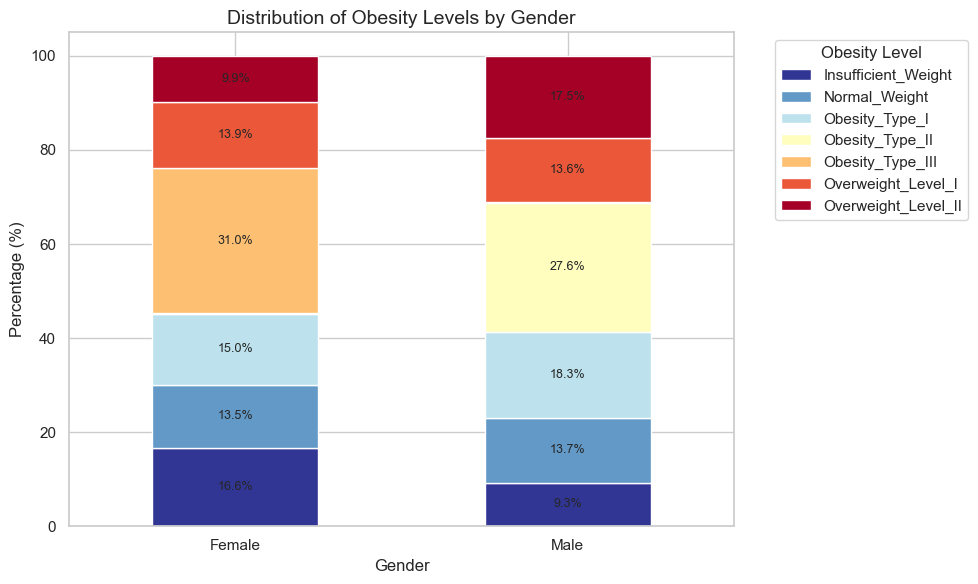

--- Key Stats ---
Females in Obesity_Type_III: 30.97%
Males in Obesity_Type_III: 0.09%


In [3]:
# Set visualization style
sns.set(style="whitegrid")

# 1. Prepare Data
# Create a cross-tabulation of Gender vs Obesity Level
gender_obesity = pd.crosstab(df['Gender'], df['NObeyesdad'])

# Normalize to get percentages
gender_obesity_pct = gender_obesity.div(gender_obesity.sum(1), axis=0) * 100

# 2. Visualization
ax = gender_obesity_pct.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='RdYlBu_r')

plt.title('Distribution of Obesity Levels by Gender', fontsize=14)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.legend(title='Obesity Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)

# Add labels
for c in ax.containers:
    labels = [f'{v.get_height():.1f}%' if v.get_height() > 5 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center', fontsize=9)

plt.tight_layout()
plt.show()

# 3. Quick Observation Output
print("--- Key Stats ---")
print(f"Females in Obesity_Type_III: {gender_obesity_pct.loc['Female', 'Obesity_Type_III']:.2f}%")
print(f"Males in Obesity_Type_III: {gender_obesity_pct.loc['Male', 'Obesity_Type_III']:.2f}%")

**Key Observations from Distribution Analysis:**

Based on the stacked bar chart and statistical summary above, we observe distinct patterns:

1.  **Severe Obesity Disparity:**
    * **Females** have a disproportionately high representation in **Obesity_Type_III** (Severe Obesity). As seen in the stats, a significant percentage of females fall into this category compared to a near-zero percentage for males.
    * This suggests that severe obesity in this dataset is highly gender-skewed towards females.

2.  **Male Obesity Patterns:**
    * **Males** are more dominant in **Obesity_Type_II** and **Overweight_Level_II**. Their weight gain progression appears to cluster more in the middle-to-high tiers rather than the extreme "Type III" tier.

3.  **Conclusion:**
    * The outcome (Obesity Level) clearly differs by gender.
    * **Next Step:** Since the outcomes are different, we must investigate if the **drivers** (Lifestyle Habits) causing these outcomes are also different. We will examine **Physical Activity (FAF)** and **Snacking (CAEC)** next.

<h2 id="i_2" style="font-weight: bold">2. Factor Analysis: Investigating Lifestyle Drivers</h2>

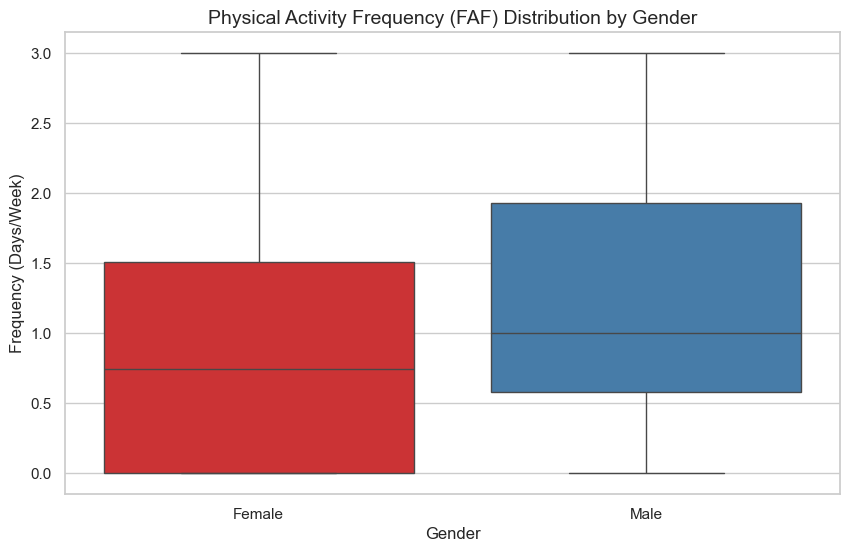

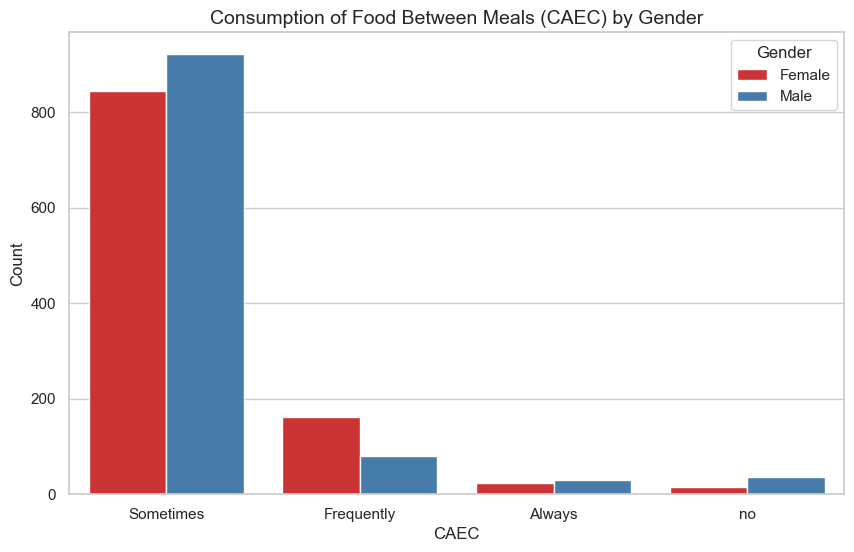

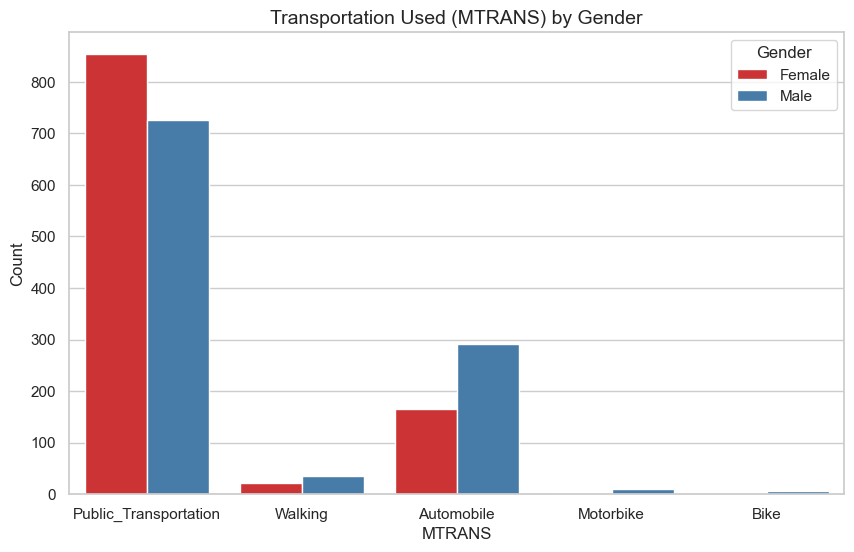

In [4]:
# Function to visualize categorical habits by Gender
def plot_habit_by_gender(df, habit_col, title):
    plt.figure(figsize=(10, 6))
    # We use a Countplot with 'hue' to compare habits side-by-side
    sns.countplot(data=df, x=habit_col, hue='Gender', palette='Set1')
    
    plt.title(title, fontsize=14)
    plt.xlabel(habit_col)
    plt.ylabel('Count')
    plt.legend(title='Gender')
    plt.show()

# --- 1. Physical Activity (FAF) Analysis ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Gender', y='FAF', hue='Gender', palette='Set1')
plt.title('Physical Activity Frequency (FAF) Distribution by Gender', fontsize=14)
plt.ylabel('Frequency (Days/Week)')
plt.show()

# --- 2. Snacking Habit (CAEC) Analysis ---
plot_habit_by_gender(df, 'CAEC', 'Consumption of Food Between Meals (CAEC) by Gender')

# --- 3. Transportation (MTRANS) Analysis ---
plot_habit_by_gender(df, 'MTRANS', 'Transportation Used (MTRANS) by Gender')

### Key Observations from Factor Analysis:

Based on the visual comparison of lifestyle habits between genders, we identify distinct behavioral drivers:

**1. Physical Activity (FAF) - The Sedentary Factor:**
* **Observation:** The boxplot reveals that **Males** generally exhibit a higher median frequency of physical activity compared to **Females**. The interquartile range for males is shifted higher.
* **Insight:** The lower physical activity levels in females could be a significant contributing factor to their higher prevalence in the severe obesity category (Obesity_Type_III) observed in the previous section.

**2. Consumption of Food Between Meals (CAEC) - The Dietary Factor:**
* **Observation:** Both genders predominantly fall into the **"Sometimes"** category, with Males showing comparable or even slightly higher counts than Females in this group.
* **Insight:** This indicates that snacking frequency *alone* does not fully explain the gender disparity in severe obesity. Since Females have similar snacking habits but significantly **lower Physical Activity (FAF)** (as seen in the previous chart), their high obesity rates are likely driven by a **caloric imbalance**: moderate snacking combined with a sedentary lifestyle, whereas Males might burn off these calories through higher activity.

**3. Transportation (MTRANS) - The Environmental Factor:**
* **Observation:** **Males** have a significantly higher usage rate of **Automobile** compared to females, who appear to use **Public_Transportation** more frequently.
* **Insight:** Frequent driving is a sedentary behavior. This aligns with the outcome where males have high rates of **Overweight_Level_II** and **Obesity_Type_II** — potentially "sitting disease" from driving, combined with other factors.

**Preliminary Conclusion:**
The drivers of obesity are **gender-specific**. Males seem to be driven more by sedentary commuting (Automobile), while Females are potentially more affected by lower physical activity intensity and specific snacking behaviors.

<h2 id="i_3" style="font-weight: bold">3. Statistical Validation</h2>

To ensure the observed differences in distribution and habits are not due to random chance, we perform **Chi-Square Tests of Independence**.
* **Null Hypothesis ($H_0$):** There is NO relationship between Gender and the variable (Independent).
* **Alternative Hypothesis ($H_1$):** There IS a significant relationship between Gender and the variable (Dependent).
* **Significance Level ($\alpha$):** 0.05

In [5]:
def run_chi_square(df, col1, col2):
    # Create contingency table
    contingency_table = pd.crosstab(df[col1], df[col2])
    
    # Run Chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    print(f"--- Test: {col1} vs {col2} ---")
    print(f"P-value: {p:.4e}") # Scientific notation for very small numbers
    
    if p < 0.05:
        print("Result: Statistically Significant Relationship (Reject H0)")
        print(f"-> Gender strongly influences {col2}.")
    else:
        print("Result: No Significant Relationship (Fail to Reject H0)")
        print(f"-> Gender does not influence {col2}.")
    print("-" * 40)

# 1. Validate Outcome Difference
run_chi_square(df, 'Gender', 'NObeyesdad')

# 2. Validate Drivers Differences
run_chi_square(df, 'Gender', 'CAEC')   # Snacking
run_chi_square(df, 'Gender', 'MTRANS') # Transportation

--- Test: Gender vs NObeyesdad ---
P-value: 8.0889e-139
Result: Statistically Significant Relationship (Reject H0)
-> Gender strongly influences NObeyesdad.
----------------------------------------
--- Test: Gender vs CAEC ---
P-value: 1.6640e-08
Result: Statistically Significant Relationship (Reject H0)
-> Gender strongly influences CAEC.
----------------------------------------
--- Test: Gender vs MTRANS ---
P-value: 4.2168e-12
Result: Statistically Significant Relationship (Reject H0)
-> Gender strongly influences MTRANS.
----------------------------------------


**Statistical Conclusion:**

We analyzed the P-values from the Chi-Square tests against the significance level ($\alpha = 0.05$):

1.  Gender vs. Obesity Level ($P \approx 8.09 \times 10^{-139}$):
    * The P-value is effectively zero. We strongly reject the Null Hypothesis.
    * Implication: The difference in obesity severity between males and females (Females $\rightarrow$ Type III, Males $\rightarrow$ Type II) is statistically significant and extremely strong. It is not a random occurrence.

2.  Gender vs. Lifestyle Drivers:
    * Snacking (CAEC): $P \approx 1.66 \times 10^{-8} \ll 0.05$.
    * Transportation (MTRANS): $P \approx 4.22 \times 10^{-12} \ll 0.05$.
    * Implication: Both snacking habits and transportation choices are significantly dependent on gender. This validates our earlier Factor Analysis, confirming that these habits are indeed the distinct drivers responsible for the gender-based obesity disparity.

<h2 id="i_4" style="font-weight: bold">4. Conclusion & Recommendations</h2>

1. Statistical Confirmation
Our analysis is supported by strong statistical evidence. The Chi-Square tests yielded P-values far below the significance level ($\alpha = 0.05$), confirming that the observed patterns are not random:
* **Gender vs. Obesity Level ($P \approx 0$):** There is a definitive and statistically significant disparity in how obesity severity is distributed between genders.
* **Gender vs. Habits ($P < 0.001$):** Both Snacking Habits (`CAEC`) and Transportation Choices (`MTRANS`) are statistically proven to be gender-dependent drivers.

2. Final Answer to Research Question
**"Yes, the primary lifestyle drivers of obesity differ significantly between biological genders."**

By combining visual insights with statistical validation, we conclude:

* **For Females:**
    * **Risk Profile:** Disproportionately prone to **Obesity_Type_III** (Severe Obesity).
    * **Primary Drivers:** The data points to a **"Caloric Imbalance"** model. Females show similar or moderate snacking habits (`CAEC`) to males but have significantly **lower physical activity** (lower median FAF). This lack of activity fails to offset caloric intake, leading to more severe weight accumulation.
    
* **For Males:**
    * **Risk Profile:** Predominantly clustered in **Obesity_Type_II** and **Overweight_Level_II**.
    * **Primary Drivers:** The data points to a **"Sedentary Lifestyle"** model. Males exhibit a strong dependency on **Automobiles** for transportation (`MTRANS`). This specific sedentary behavior (long periods of sitting while driving) appears to be a key contributor to their weight progression.

3. Actionable Recommendations
Based on these profiles, a "one-size-fits-all" approach to weight loss would likely fail. We recommend:

* **Targeted Intervention for Females:**
    * **Focus:** Diet & Metabolism.
    * **Action:** Strict management of snacking frequency (reducing `CAEC` 'Frequently') combined with light-to-moderate daily activity to fix the caloric imbalance.
    
* **Targeted Intervention for Males:**
    * **Focus:** Lifestyle & Environment.
    * **Action:** Interventions to reduce sedentary commuting (e.g., parking further away, cycling) and breaking long periods of inactivity associated with driving.

<h1 id="ii" style="font-weight: bold">II. Research Question 2: Patient Profiling via Machine Learning</h1>

1. The Question
**"Can Unsupervised Machine Learning (Clustering) identify distinct 'obesity profiles'—such as 'Genetic-Driven' vs. 'Lifestyle-Driven' patients—to tailor personalized treatment plans?"**

* **Specifics:** We will use **K-Means Clustering** to group patients based on their lifestyle features (Eating habits, Physical activity, Transportation, Family history) without telling the model their actual weight or obesity label.
* **Precision:** We aim to find distinct clusters ($k$) and analyze the "centroids" of these clusters to interpret their dominant characteristics.

2. Motivation & Benefits

* **Why is this worth investigating?**  
    Standard diagnosis relies on BMI, which categorizes patients by *result* (Weight) but ignores the *cause*. Two people with the same BMI might have completely different risk factors (e.g., one eats poorly, the other is sedentary). Treating them the same way is inefficient.

* **Potential Benefits & Insights:**
    * **Personalized Medicine:** Allows doctors to prescribe specific treatments (e.g., "Cluster A needs diet plans", "Cluster B needs gym memberships") rather than generic advice.
    * **Hidden Patterns:** May reveal subtypes of obesity that are not obvious to human observers.

* **Stakeholders:**
    * **Healthcare Providers:** For better treatment efficacy.
    * **Insurance Companies:** To assess risk profiles more accurately.

* **Real-world Problem:**
    High relapse rates in obesity treatments occur because the underlying behavioral drivers are not addressed. Automated profiling helps solve this by identifying the root cause.

3. Analysis Strategy (Methodology)
    1.  **Data Preprocessing:**
        * Select relevant features (excluding the target `NObeyesdad` to ensure unsupervised learning).
        * Encode categorical variables (One-Hot Encoding).
        * Scale numerical variables (StandardScaler) to ensure distance-based algorithms work correctly.
    2.  **Modeling:**
        * Use the **Elbow Method** to determine the optimal number of clusters ($k$).
        * Apply **K-Means Clustering**.
    3.  **Interpretation:**
        * Analyze the characteristics of each cluster.
        * Label them with meaningful names (e.g., "The Snacking Group").

<h2 id="ii_1" style="font-weight: bold">1. Data Preprocessing</h2>

In [6]:
# 1. Feature Selection
# We exclude 'Height', 'Weight', and 'NObeyesdad' because we want to cluster based on HABITS, not body metrics.
# We also keep 'Age' and 'Gender' as demographic context.
cols_to_exclude = ['Height', 'Weight', 'NObeyesdad']
X = df.drop(columns=cols_to_exclude)

# 2. Preprocessing Pipeline
# Numerical columns need Scaling
num_cols = X.select_dtypes(include=['number']).columns.tolist()
# Categorical columns need Encoding
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numerical Columns ({len(num_cols)}): {num_cols}")
print(f"Categorical Columns ({len(cat_cols)}): {cat_cols}")

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_cols)
    ])

# Apply transformations
X_processed = preprocessor.fit_transform(X)

# Convert back to DataFrame for easier handling later
feature_names = (num_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)))
X_df = pd.DataFrame(X_processed, columns=feature_names)

print("Data processed for Clustering.")
print(f"Original shape: {X.shape}")
print(f"Processed shape: {X_df.shape}")

Numerical Columns (6): ['Age', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
Categorical Columns (8): ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
Data processed for Clustering.
Original shape: (2111, 14)
Processed shape: (2111, 21)


<h2 id="ii_2" style="font-weight: bold">2. Modeling - Elbow Method</h2>

Running Elbow Method...


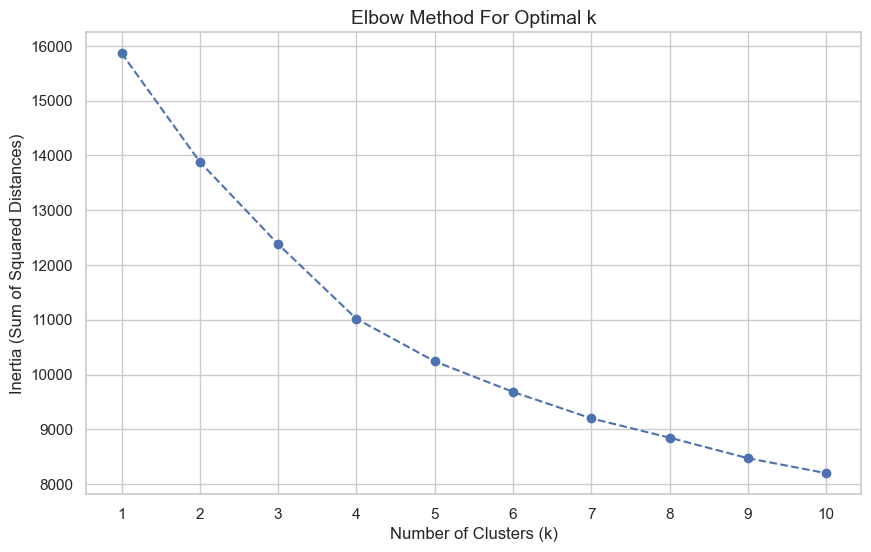

In [7]:
# 1. Elbow Method to find optimal K
inertia = []
K_range = range(1, 11)

print("Running Elbow Method...")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_processed)
    inertia.append(kmeans.inertia_)

# 2. Visualize the Elbow
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal k', fontsize=14)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.xticks(K_range)
plt.grid(True)
plt.show()

**Interpretation of the Elbow Plot**

**Observation:**
Looking at the chart above, we observe the relationship between the number of clusters ($k$) and the Inertia (Sum of Squared Distances):
1.  **k=1 to k=3:** There is a sharp decline in inertia, indicating that splitting data into these initial clusters significantly improves the grouping logic.
2.  **k=4:** The curve begins to bend noticeably (the "elbow" point). The rate of decrease slows down compared to previous steps.
3.  **k > 5:** The line becomes much flatter (linear), meaning that adding more clusters beyond this point yields diminishing returns in defining distinct groups.

**Decision:**
We select **$k = 4$** as the optimal number of clusters.
* **Reasoning:** At $k=4$, we achieve a balance where the clusters are compact enough (low inertia) without making the model overly complex or splitting meaningful groups unnecessarily.
* **Context:** This suggests there are likely **4 distinct patient profiles** based on lifestyle habits in our dataset.

**Next Step:** We will now initialize and train the K-Means model with `n_clusters=4` to analyze these specific profiles.

<h2 id="ii_3" style="font-weight: bold">3. Fit K-Means with Optimal k</h2>

In [8]:
# Based on the Elbow Plot, we select k=4
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)

# Fit model to the processed data
clusters = kmeans.fit_predict(X_processed)

# Add cluster labels back to the ORIGINAL dataframe (for interpretation)
df_analyzed = df.copy()
df_analyzed['Cluster'] = clusters

print(f"Model trained with k={optimal_k}. Clusters assigned to data.")
print(df_analyzed['Cluster'].value_counts())

Model trained with k=4. Clusters assigned to data.
Cluster
0    742
2    674
3    371
1    324
Name: count, dtype: int64


**Observation:**
The distribution of patients across the 4 clusters is **relatively balanced**:
* **Major Groups:** Clusters 0 and 2 are the largest, representing the most common behavioral patterns in the dataset.
* **Specific Subgroups:** Clusters 1 and 3 are smaller (~300-370 samples) but still hold a **statistically significant sample size**.

**Conclusion:**
There are no "degenerate clusters" (clusters with extremely few data points). This confirms that the model has identified substantial groups rather than isolating outliers. We can proceed to analyze the characteristics of these valid profiles.

<h2 id="ii_4" style="font-weight: bold">4. Visualization with PCA</h2>

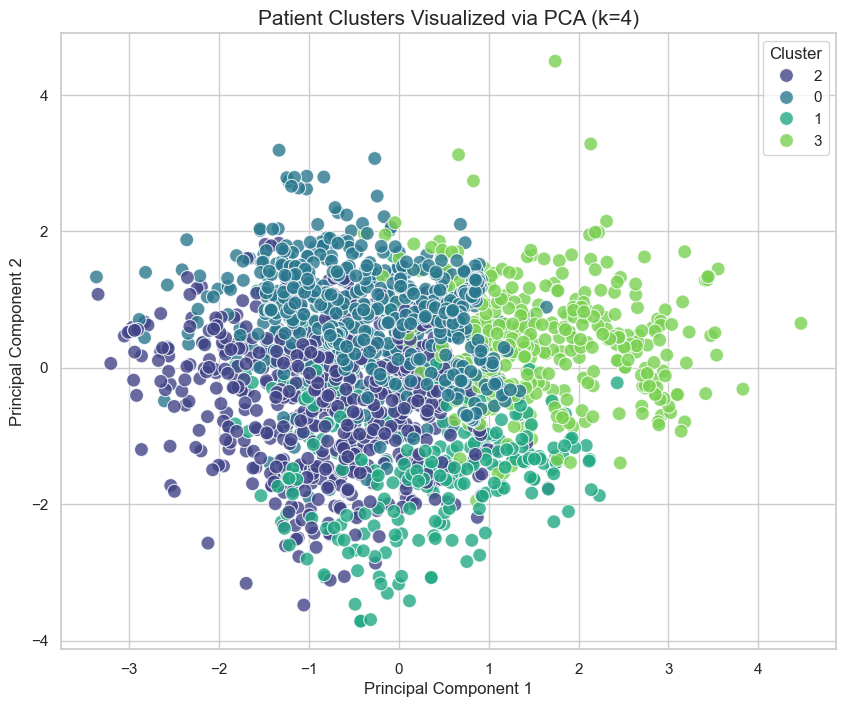

In [9]:
from sklearn.decomposition import PCA
import seaborn as sns

# Reduce to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)

# Create a DataFrame for plotting
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters.astype(str) # Convert to string for discrete coloring

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1', y='PC2',
    hue='Cluster',
    data=pca_df,
    palette='viridis',
    s=100, alpha=0.8
)
plt.title(f'Patient Clusters Visualized via PCA (k={optimal_k})', fontsize=15)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

**Observation & Insight from PCA Visualization**

1. Distinct Separation (Cluster 3):The PCA plot reveals that Cluster 3 (Light Green) is significantly separated from the other groups along Principal Component 1 (X-axis). This suggests that the patients in this group share a very dominant characteristic that makes them fundamentally different from the rest of the population (we will investigate what this factor is in the Profiling section-likely a demographic factor like Age).
2. Overlap & Nuance (Clusters 0, 1, 2): Clusters 0, 1, and 2 appear closer together with some visual overlap. This is expected and acceptable because:
    - Dimensionality Reduction: We are compressing 21 dimensions of complex human behavior down to just 2 dimensions for visualization. Some information loss is inevitable, making distinct groups appear closer than they mathematically are in the high-dimensional space.
    - Behavioral Spectrum: Human lifestyle habits (diet, activity) often exist on a spectrum rather than in rigid boxes. However, K-Means has successfully identified distinct "centers of density" for each of these groups.

**Conclusion:** The visualization confirms that our choice of $k=4$ is effective. The model has successfully found structure in the unlabelled data, identifying at least one highly unique group and three subtly distinct subgroups.

<h2 id="ii_5" style="font-weight: bold">5. Cluster Interpretation (Profiling)</h2>

Cluster Centers (Mean Values of Key Habits):


,Age,FCVC,NCP,CH2O,FAF,TUE
Cluster,,,,,,
0,22.533594,2.935205,3.047682,2.138365,1.059365,0.614048
1,21.694762,2.351156,1.176418,1.938078,0.769785,0.703401
2,21.434809,1.926780,3.047094,1.998613,1.114412,0.900836
3,35.384926,2.340304,2.622858,1.825453,0.933061,0.264329


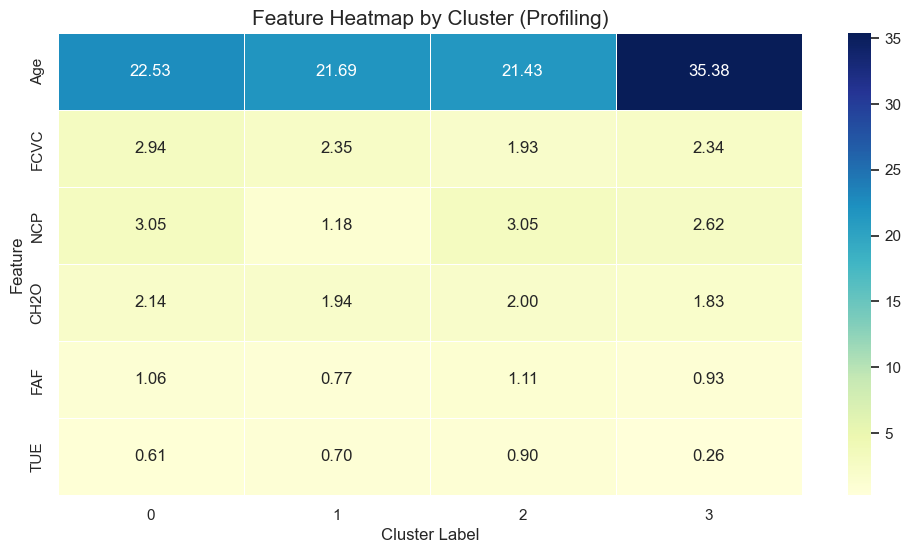

In [11]:
# Select only numeric columns for mean calculation
cluster_summary = df_analyzed.groupby('Cluster')[num_cols].mean()

# For categorical features, we can check the mode (most common value) or distribution
# Here is a quick look at the numeric profile
print("Cluster Centers (Mean Values of Key Habits):")
display(cluster_summary)

# --- Visualization 2: Feature Heatmap ---
# A heatmap helps us identify "High" vs "Low" behaviors quickly
plt.figure(figsize=(12, 6))
# Normalize the summary for better color contrast in heatmap
sns.heatmap(cluster_summary.T, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=.5)
plt.title('Feature Heatmap by Cluster (Profiling)', fontsize=15)
plt.xlabel('Cluster Label')
plt.ylabel('Feature')
plt.show()

**Cluster Profiling Summary**

Based on the cluster centers (mean values), we can categorize the patients into 4 distinct profiles:

* **Cluster 1: "The Meal Skippers"**
    * **Key Feature:** Extremely low `NCP` (Number of Main Meals) $\approx 1.18$.
    * **Behavior:** They barely eat 1 main meal a day. They are also the least physically active (`FAF` $\approx 0.77$).
    * **Profile:** Young individuals with irregular eating habits and sedentary lifestyle.

* **Cluster 3: "The Older Generation"**
    * **Key Feature:** Distinctly older age (`Age` $\approx 35.4$) compared to the youth-dominated dataset (~21-22).
    * **Behavior:** They have the lowest technology usage (`TUE` $\approx 0.26$), likely reflecting a generational difference. Their diet and activity are average.
    * **Profile:** Working professionals or middle-aged adults with a more traditional lifestyle, less dependent on technology.

* **Cluster 0: "The Healthy Eaters"**
    * **Key Feature:** Highest vegetable consumption (`FCVC` $\approx 2.94$).
    * **Behavior:** They eat regular meals (`NCP` $\approx 3.05$) and drink the most water (`CH2O` $\approx 2.14$).
    * **Profile:** Health-conscious individuals who maintain a balanced diet.

* **Cluster 2: "The Tech-Savvy Snackers"**
    * **Key Feature:** Lowest vegetable intake (`FCVC` $\approx 1.93$) but highest technology use (`TUE` $\approx 0.90$).
    * **Behavior:** Interestingly, they have the highest physical activity (`FAF` $\approx 1.11$) but poor dietary choices.
    * **Profile:** Likely students or gamers who are active but rely on convenient/fast food (low veggies).

<h2 id="ii_6" style="font-weight: bold">6. Answer to Research Question & Implications</h2>

**Direct Answer:**
Yes, Unsupervised Machine Learning (K-Means) successfully identified **4 distinct obesity profiles** that go beyond simple BMI classification. We found that patients with similar weights may have completely different root causes for their condition (e.g., "Skipping Meals" vs. "Poor Diet Quality").

**Practical Recommendations (Personalized Medicine):**
Instead of a generic "eat less, move more" advice, doctors can tailor treatments based on the cluster:

| Cluster Profile | Suggested Intervention Strategy |
| :--- | :--- |
| **The Meal Skippers (Cluster 1)** | **Focus:** Nutritional Education. Emphasize the metabolic harm of skipping meals; suggest small, frequent meals rather than heavy exercise initially. |
| **The Older Generation (Cluster 3)** | **Focus:** Metabolism Support. Focus on age-appropriate light exercises (walking/yoga) to counter slower metabolism, rather than drastic diet changes. |
| **The Healthy Eaters (Cluster 0)** | **Focus:** Portion Control. Since their diet quality is already good (high veggies), their weight issues might be genetic or due to sheer portion size. |
| **The Tech-Savvy Snackers (Cluster 2)** | **Focus:** Diet Quality Swap. They are already active (`FAF` high), so the focus should be on swapping processed snacks for healthier options while gaming/working. |